In [3]:
# import pandas as pd
import numpy as np
import pandas as pd
# Đường dẫn đến tệp dữ liệu trên Kaggle
file_path = '/kaggle/input/vindr-mammo-dataset/breast-level_annotations.csv'

df = pd.read_csv(file_path).head(2000)
df.loc[df['breast_birads'] == 'BI-RADS 1', 'breast_birads'] = '1'
df.loc[df['breast_birads'] == 'BI-RADS 2', 'breast_birads'] = '2'
df.loc[df['breast_birads'] == 'BI-RADS 3', 'breast_birads'] = '3'
df.loc[df['breast_birads'] == 'BI-RADS 4', 'breast_birads'] = '4'
df.loc[df['breast_birads'] == 'BI-RADS 5', 'breast_birads'] = '5'

df_new = df[['image_id', 'breast_birads']].copy()
groups = df_new.groupby('breast_birads')
group_names = list(groups.groups.keys())[0:5]

#foil_df+ explained_df (rank 1)
n1 = group_names[0]
c1_df = groups.get_group(n1).head(2).reset_index(drop=True)
print(c1_df)


#corpus_df(rank 3)
n2 = group_names[2]
c3_df = groups.get_group(n2).head(2).reset_index(drop=True)
print(c3_df)

#ex(rank2)
n3 = group_names[1]
c2_df=groups.get_group(n3).tail(2).reset_index(drop=True)
x2_df=groups.get_group(n3).head(2).reset_index(drop=True)
print(c2_df)
image_folder = "/kaggle/input/vindr-mammo-dataset/Processed_Images"
# from img_id find img_path
def find_images(image_id, folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file == image_id+'.png':
                image_paths=os.path.join(root, file)
    return image_paths

                           image_id breast_birads
0  dd9ce3288c0773e006a294188aadba8e             1
1  57fbdd278af5c8789a02b355c11620d4             1
                           image_id breast_birads
0  aad38467d1f04cedf300c9c8305a3536             3
1  2ccefd9e7701acf52c92275e844f7578             3
                           image_id breast_birads
0  5e65ff8020d615e6561df8aee72894ef             2
1  372aca2e23701e07dbec9ee47a8b1d86             2


In [4]:
import os
import torch
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader,random_split
from torch.utils.data import TensorDataset
#creat dataset return tensor+ label
class MyDataset():
    def __init__(self, df, image_dir):
        self.image_ids = df.iloc[:, 0]  
        self.labels = df.iloc[:, 1]     
        self.image_dir = image_dir
        if df is not None and df.equals("explained_df"):
            self.downsample_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
        else:
            self.downsample_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                #transforms.RandomVerticalFlip(),
                #transforms.RandomHorizontalFlip(),
                #transforms.RandomRotation(degrees=30),
                transforms.ToTensor(),
            ])
       
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_id=self.image_ids.iloc[index]
        image_path=find_images(image_id,self.image_dir)
        image = Image.open(image_path)
        do = self.downsample_transform(image)
        img = torch.cat([do, do, do], dim=0)
        label = self.labels.iloc[index]
        return img,label


In [5]:
c1_dataset=MyDataset(c1_df,image_folder)
c2_dataset=MyDataset(c2_df,image_folder)
c3_dataset=MyDataset(c3_df,image_folder)
x2_dataset=MyDataset(x2_df,image_folder)

c1_dataloader=DataLoader(c1_dataset, batch_size=1, shuffle=False)
c2_dataloader=DataLoader(c2_dataset, batch_size=1, shuffle=False)
c3_dataloader=DataLoader(c3_dataset, batch_size=1, shuffle=False)
x2_dataloader=DataLoader(x2_dataset, batch_size=1, shuffle=False)

In [ ]:
from PIL import Image
# function return raw img 
def raw_input(img_id,folder):
    img_path = find_images(img_id, folder)
    i = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image to fit the model's input size
    
    ])
    image = preprocess(i)

    return image

    

In [7]:
"""
PyTorch implementation of the SimCLR ResNet model. Code taken and modified from
https://github.com/tonylins/simclr-converter.
"""

import torch
import torch.nn as nn


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding."""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    """Basic block."""

    expansion = 1
    __constants__ = ["downsample"]

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when
        # stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """Bottleneck."""

    expansion = 4
    __constants__ = ["downsample"]

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        self.downsample = (
            downsample  # hack: moving downsample to the first to make order correct
        )
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    """ResNet."""

    def __init__(
        self,
        block,
        layers,
        num_classes=1000,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
        width_mult=1,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64 * width_mult
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64 * width_mult, layers[0])
        self.layer2 = self._make_layer(
            block,
            128 * width_mult,
            layers[1],
            stride=2,
            dilate=replace_stride_with_dilation[0],
        )
        self.layer3 = self._make_layer(
            block,
            256 * width_mult,
            layers[2],
            stride=2,
            dilate=replace_stride_with_dilation[1],
        )
        self.layer4 = self._make_layer(
            block,
            512 * width_mult,
            layers[3],
            stride=2,
            dilate=replace_stride_with_dilation[2],
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion * width_mult, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block
        # behaves like an identity.
        # This improves the model by 0.2~0.3% according to
        # https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x, apply_eval_head=False):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        if apply_eval_head:
            x = self.fc(x)

        return x

    def forward(self, x, apply_eval_head=False):
        return self._forward_impl(x, apply_eval_head=apply_eval_head)


def resnet50x1(**kwargs):
    """ResNet50 (1x)"""
    return ResNet(Bottleneck, [3, 4, 6, 3], width_mult=1)


def resnet50x2(**kwargs):
    """ResNet50 (2x)"""
    return ResNet(Bottleneck, [3, 4, 6, 3], width_mult=2)


def resnet50x4(**kwargs):
    """ResNet50 (4x)"""
    return ResNet(Bottleneck, [3, 4, 6, 3], width_mult=4)

In [8]:
def load_encoder(encoder_name: str) -> nn.Module:
    """Load encoder."""
    encoder = None
    if "simclr" in encoder_name:
        if encoder_name == "simclr_x1":
            encoder = resnet50x1()
            state_dict_path = '/kaggle/input/simclr1/resnet50-1x.pth'
        elif encoder_name == "simclr_x2":
            encoder = resnet50x2()
            state_dict_path = os.path.join(state_dict_path, "resnet50-2x.pth")
        elif encoder_name == "simclr_x4":
            encoder = resnet50x4()
            state_dict_path = os.path.join(state_dict_path, "resnet50-4x.pth")
        else:
            _encoder_not_implemented_error(encoder_name)
        state_dict = torch.load(state_dict_path, map_location="cpu")
        encoder.load_state_dict(state_dict["state_dict"])
    else:
        _encoder_not_implemented_error(encoder_name)
    return encoder

In [9]:
pip install vit-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install timm


Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
from torchvision.models import resnet50, resnet152, densenet121
from vit_pytorch import ViT
import timm
import torch

def load_model(model_type, checkpoint_path):
    if model_type == 'resnet50':
        model = resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 512)
    elif model_type == 'resnet152':
        model = resnet152(pretrained=False)
    elif model_type == 'densenet121':
        model = densenet121(pretrained=True)
        num_classes = 512
        model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
    elif model_type == 'vit':
        model_name = 'vit_base_patch16_224'  # Specify the model name
        num_classes = 512  # Number of output classes (adjust as needed)
        model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)

    else:
        raise ValueError(f"Loại mô hình '{model_type}' không được hỗ trợ.")
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    # Extract the model state dictionary from the checkpoint
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint  # Assuming the entire checkpoint is the state_dict
    
    # Adjust state dictionary keys if necessary
    new_state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    return model
checkp='/kaggle/input/ver1-checkpoint/version 1/weights_setting3/vit_base_patch16_224BasedModel/best.pt'
encoder=load_model('vit',checkp)


In [12]:
from typing import Optional
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
class ExplanationBase(nn.Module):
    def __init__(
        self,
        encoder: nn.Module,
        device: Optional[int] = None,
    ) -> None:
        super().__init__()
        self.encoder = encoder
        self.device = device

    def _encode(self, dataloader: DataLoader) -> torch.Tensor:
        encoder_device = self.device
        if encoder_device is None:
            encoder_device = [param.device for param in self.encoder.parameters()][0]
        rep = []
        for x,_ in dataloader:
            x = self.encoder(x)
            rep.append(x)
        return torch.cat(rep)

    def _encode_mean(self, dataloader: DataLoader, normalize: bool) -> torch.Tensor:
        encoder_device = self.device
        if encoder_device is None:
            encoder_device = [param.device for param in self.encoder.parameters()][0]
        rep = []
        for x,_ in dataloader:
            x = x.to(encoder_device)
            x = self.encoder(x).detach()  # Detach right away to minimize memory usage.
            if normalize:
                x /= x.norm(dim=-1).unsqueeze(-1)
            x = x.cpu()
            rep.append(x)
        return torch.cat(rep).mean(dim=0)

    @staticmethod
    def _compute_difference_norm(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Compute pairwise difference norms."""
        return torch.norm(x.unsqueeze(1) - y.unsqueeze(0), dim=-1)

    def _compute_cosine_similarity(
        self, x: torch.Tensor, y: torch.Tensor
    ) -> torch.Tensor:
        """Compute pairwise cosine similarities."""
        return self._compute_dot_product(x, y) / (
            x.norm(dim=-1).unsqueeze(1) * y.norm(dim=-1).unsqueeze(0)
        )

    @staticmethod
    def _compute_dot_product(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Compute pairwise dot products."""
        return (x.unsqueeze(1) * y.unsqueeze(0)).sum(dim=-1)


Tính toán norm của sự khác biệt từng cặp giữa các vector trong hai tensor x và y bằng việc thêm chiều và trừ 2 vector
Tích vô hướng từng cặp sau khi thêm chiều ra cosine

In [13]:
class CorpusBasedExplanation(ExplanationBase):

    def __init__(
        self,
        encoder: nn.Module,
        corpus_dataloader: DataLoader,
        batch_size: int = 1,
        device: Optional[int] = None,
    ) -> None:
        super().__init__(encoder=encoder, device=device)
        self.corpus_dataloader = corpus_dataloader

        self.corpus_rep = self._encode(self.corpus_dataloader)
        self.corpus_size = self.corpus_rep.size(0)
        self.rep_dim = self.corpus_rep.size(-1)
        self.corpus_rep_dataloader = DataLoader(
            TensorDataset(self.corpus_rep),
            batch_size=batch_size,
            shuffle=False,
        )


encoder corpus

In [14]:
class CorpusSimilarity(CorpusBasedExplanation):
    def __init__(
        self,
        encoder: nn.Module,
        corpus_dataloader: DataLoader,
        normalize: bool,
        batch_size: int = 1,
        explicand_encoder: Optional[nn.Module] = None,
        device: Optional[int] = None,
    ) -> None:
        super().__init__(
            encoder=encoder,
            corpus_dataloader=corpus_dataloader,
            batch_size=batch_size,
            device=device,
        )
        self.normalize = normalize
        self.corpus_rep_mean = self._encode_mean(
            self.corpus_dataloader, normalize=self.normalize
        )

        if not explicand_encoder:
            self.explicand_encoder = encoder
        else:
            self.explicand_encoder = explicand_encoder

    def _rep_mean_forward(self, explicand: torch.Tensor) -> torch.Tensor:
        explicand_rep = self.encoder(explicand)
        corpus_similarity = (
            explicand_rep * self.corpus_rep_mean.to(explicand_rep.device)
        ).sum(dim=-1)
        if self.normalize:
            corpus_similarity /= explicand_rep.norm(dim=-1)
        return corpus_similarity

    def _rep_pairwise_forward(self, explicand: torch.Tensor) -> torch.Tensor:
        return self._compute_similarity(
            explicand, self.corpus_rep_dataloader, self.corpus_size
        )

    def forward(
        self, explicand: torch.Tensor, implementation: str = "mean"
    ) -> torch.Tensor:
        """
        Forward  pass.

        Args:
        ----
            explicand: Input explicands to explain, with shape `(batch_size, *)`, where
                * denotes the encoder input size of one sample.
            implementation: "mean" for using the foil representation mean to compute
                similarity. "pairwise" for computing the similarity between each
                explicand and all foil samples then averaging. The two implementations
                return the same results.
        """
        available_implementations = ["mean", "pairwise"]
        if implementation == "mean":
            return self._rep_mean_forward(explicand)
        elif implementation == "pairwise":
            return self._rep_pairwise_forward(explicand)
        else:
            raise NotImplementedError(
                f"implementation={implementation} is"
                f" not one of {available_implementations}!"
            )

    def _compute_similarity(
        self, explicand: torch.Tensor, rep_dataloader: DataLoader, rep_data_size: int
    ) -> torch.Tensor:
        explicand_rep = self.explicand_encoder(explicand)
        similarity = 0
        for (x,) in rep_dataloader:
            x = x.to(explicand_rep.device)
            if self.normalize:
                x = self._compute_cosine_similarity(explicand_rep, x)
            else:
                x = self._compute_dot_product(explicand_rep, x)
            x = x.sum(dim=1)
            similarity += x
        return similarity / rep_data_size  # Average over number of comparisons.

 An explicand's average cosine or dot product similarity score with a corpus.
 tính toán độ tương đồng giữa một explicand (dữ liệu đầu vào) và một corpus bằng các phương pháp khác nhau (mean hoặc pairwise) 


In [15]:
class ContrastiveCorpusSimilarity(CorpusSimilarity):
    """
    An explicand's cosine or dot product similarity score with a corpus vs. a foil.

    Args:
    ----
        encoder: Encoder module to explain.
        corpus_dataloader: Data loader of corpus examples to be encoded by `encoder`.
        foil_dataloader: Data loader of foil examples to be encoded by `encoder`.
        normalize: Whether to normalize dot product similarity by product of vector
            norms (that is, whether to use cosine similarity).
        batch_size: Mini-batch size for loading the corpus and foil representations.
        explicand_encoder: Optional alternative encoder for explicand.  Same as
            encoder by default.
        device: Optional device to perform encoding on.
    """

    def __init__(
        self,
        encoder: nn.Module,
        corpus_dataloader: DataLoader,
        foil_dataloader: DataLoader,
        normalize: bool,
        batch_size: int = 1,
        explicand_encoder: Optional[nn.Module] = None,
        device: Optional[int] = None,
    ) -> None:
        super().__init__(
            encoder=encoder,
            corpus_dataloader=corpus_dataloader,
            normalize=normalize,
            batch_size=batch_size,
            explicand_encoder=explicand_encoder,
            device=device,
        )
        self.foil_dataloader = foil_dataloader
        self.foil_rep = self._encode(self.foil_dataloader)
        self.foil_size = self.foil_rep.size(0)
        self.foil_rep_dataloader = DataLoader(
            TensorDataset(self.foil_rep),
            batch_size=batch_size,
            shuffle=False,
        )
        self.foil_rep_mean = self._encode_mean(
            self.foil_dataloader, normalize=self.normalize
        )

    def _rep_mean_forward(self, explicand: torch.Tensor) -> torch.Tensor:
        explicand_rep = self.explicand_encoder(explicand)
        corpus_similarity = (
            explicand_rep * self.corpus_rep_mean.to(explicand_rep.device)
        ).sum(dim=-1)
        foil_similarity = (
            explicand_rep * self.foil_rep_mean.to(explicand_rep.device)
        ).sum(dim=-1)
        if self.normalize:
            corpus_similarity /= explicand_rep.norm(dim=-1)
            foil_similarity /= explicand_rep.norm(dim=-1)
        return corpus_similarity - foil_similarity

    def _rep_pairwise_forward(self, explicand: torch.Tensor) -> torch.Tensor:
        corpus_similarity = self._compute_similarity(
            explicand, self.corpus_rep_dataloader, self.corpus_size
        )
        foil_similarity = self._compute_similarity(
            explicand, self.foil_rep_dataloader, self.foil_size
        )
        return corpus_similarity - foil_similarity

    def forward(
        self, explicand: torch.Tensor, implementation: str = "mean"
    ) -> torch.Tensor:
        """
        Forward  pass.

        Args:
        ----
            explicand: Input explicands to explain, with shape `(batch_size, *)`, where
                * denotes the encoder input size of one sample.
            implementation: "mean" for using the foil representation mean to compute
                similarity. "pairwise" for computing the similarity between each
                explicand and all foil samples then averaging. The two implementations
                return the same results.
        """
        available_implementations = ["mean", "pairwise"]
        if implementation == "mean":
            return self._rep_mean_forward(explicand)
        elif implementation == "pairwise":
            return self._rep_pairwise_forward(explicand)
        else:
            raise NotImplementedError(
                f"implementation={implementation} is"
                f" not one of {available_implementations}!"
            )


 An explicand's cosine or dot product similarity score with a corpus vs. a foil.


In [16]:
ex1_model=ContrastiveCorpusSimilarity(encoder=encoder,corpus_dataloader=c1_dataloader,foil_dataloader=c2_dataloader,normalize=True,batch_size=1,explicand_encoder=encoder,device=None)
ex2_model=ContrastiveCorpusSimilarity(encoder=encoder,corpus_dataloader=c3_dataloader,foil_dataloader=c2_dataloader,normalize=True,batch_size=1,explicand_encoder=encoder,device=None)


load explain model

In [17]:
pip install captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [27]:
"""
RISE: Randomized Input Sampling for Explanation of Black-box Models proposed by Petsiuk
et al. 2018.
"""
from typing import Callable, Tuple, Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import Attribution


class RISE(Attribution):
    """
    RISE for images proposed by Petsiuk et al. 2018.

    Args:
    ----
        forward_func: A function that returns a one-dimensional output for each input
            sample.
    """

    def __init__(self, forward_func: Union[Callable, nn.Module]) -> None:
        super().__init__(forward_func=forward_func)

    def attribute(
        self,
        inputs: torch.Tensor,
        grid_shape: Tuple[int, int],
        baselines: Union[float, torch.Tensor] = 0,
        mask_prob: float = 0.5,
        n_samples: int = 2000,
        normalize_by_mask_prob: bool = True,
    ) -> torch.Tensor:
        """
        Attribute feature importance to each pixel.

        Args:
        ----
            inputs: A batch of images with shape
                `(batch_size, channel_size, img_h, img_w)`.
            grid_shape: A tuple of integers indicating the smaller grid shape
                `(grid_h, grid_w)` that's upsampled as a mask.
            baselines: Values for replacing the original inputs when masked.
            mask_prob: Probability of masking a pixel in the smaller binary mask.
            n_samples: Number of masks per input image.
            normalize_by_mask_prob: Whether to normalize each RISE attribution score
                by `mask_prob` as in the original paper.

        Returns
        -------
            A tensor with shape `(batch_size, channel_size, img_h, img_w)` for the
            importance score of each pixel. The values across `channel_size` are all
            the same because importance scores are computed at the pixel level, not the
            pixel-channel level. The dimension `channel_size` is retained for keeping
            the standard that attribution output should have the same shape as the
            input.
        """
        batch_size, channel_size, img_h, img_w = inputs.shape
        device = inputs.device
        scores = torch.zeros(batch_size, channel_size, img_h, img_w).to(device)
        for i in range(n_samples):
            masks = self.generate_mask(
                img_h=img_h,
                img_w=img_w,
                grid_h=grid_shape[0],
                grid_w=grid_shape[1],
                mask_prob=mask_prob,
                n_masks=batch_size,
            ).to(device)
            score = self.forward_func(inputs * masks + baselines * (1 - masks)).detach()
            if i == 0:  # Check output dimension on the first iteration.
                assert (
                    len(score.shape) == 1
                ), "RISE.forward_func needs to return a one-dimensional output!"
            score = score.view(batch_size, 1, 1, 1) * masks
            scores += score
        scores /= n_samples
        if normalize_by_mask_prob:
            scores /= mask_prob
        return scores

    @staticmethod
    def generate_mask(
        img_h: int,
        img_w: int,
        grid_h: int,
        grid_w: int,
        mask_prob: float = 0.5,
        n_masks: int = 50,
    ) -> torch.Tensor:
        """
        Generate masks for dimming input images.

        The mask generation process is summarized as the following.
        1. Sample a binary mask of size `(grid_h, grid_w)`.
        2. Upsample the binary mask through bilinear interpolation to size
            `((grid_h + 1) * (img_h // grid_h), (grid_w + 1) * (img_w // grid_w))`.
        3. Randomly crop a contiguous area of size `(img_h, img_w)` to form the final
            mask.

        Args:
        ----
            img_h: Original image height.
            img_w: Original image width.
            grid_h: Smaller binary mask height.
            grid_w: Smaller binary mask width.
            mask_prob: Probability of masking a pixel in the smaller binary mask.
            n_masks: Number of independent masks to generate.

        Returns
        -------
            A tensor of size `(n_masks, 1, img_h, img_w)` of independently sampled
            masks.
        """
        grid_h_pixel_size = img_h // grid_h
        grid_w_pixel_size = img_w // grid_w
        mask = (torch.rand(n_masks, 1, grid_h, grid_w) < mask_prob) * 1.0
        mask = F.interpolate(
            mask,
            size=((grid_h + 1) * grid_h_pixel_size, (grid_w + 1) * grid_w_pixel_size),
            mode="bilinear",
            align_corners=False,
        )
        shift_h = np.random.randint(grid_h_pixel_size)
        shift_w = np.random.randint(grid_w_pixel_size)
        mask = mask[:, :, shift_h : (shift_h + img_h), shift_w : (shift_w + img_w)]
        return mask

tính toán mức độ quan trọng của từng pixel trong ảnh đầu vào. 

mask method rise

In [28]:
grid_shape = (7, 7)
attribution_model1 = RISE(ex1_model)# rank 1-2
attribution_model2 = RISE(ex2_model)#rank 2-3
attribution_list1 = []
attribution_list2 = []
get_baseline = transforms.GaussianBlur(21, sigma=5.0)


for explicand,_ in x2_dataloader:
    attribution1 = attribution_model1.attribute(
                    inputs=explicand,
                    grid_shape=grid_shape,
                    baselines = get_baseline(explicand),
                    mask_prob=0.5,
                    n_samples=50,
                    normalize_by_mask_prob=True,
        )
    attribution2 = attribution_model2.attribute(
                    inputs=explicand,
                    grid_shape=grid_shape,
                    baselines = get_baseline(explicand),
                    mask_prob=0.5,
                    n_samples=50,
                    normalize_by_mask_prob=True,
        )
    attribution_list1.append(attribution1)
    attribution_list2.append(attribution2)
output1= torch.cat(attribution_list1)
output2= torch.cat(attribution_list2)

print(output1)
print(output2)

tensor([[[[ 0.1302,  0.1303,  0.1297,  ...,  0.0910,  0.0917,  0.0922],
          [ 0.1289,  0.1290,  0.1284,  ...,  0.0896,  0.0903,  0.0908],
          [ 0.1276,  0.1277,  0.1271,  ...,  0.0883,  0.0889,  0.0894],
          ...,
          [ 0.0971,  0.0984,  0.0992,  ...,  0.0116,  0.0104,  0.0095],
          [ 0.0972,  0.0985,  0.0993,  ...,  0.0121,  0.0109,  0.0099],
          [ 0.0973,  0.0986,  0.0994,  ...,  0.0126,  0.0114,  0.0104]],

         [[ 0.1302,  0.1303,  0.1297,  ...,  0.0910,  0.0917,  0.0922],
          [ 0.1289,  0.1290,  0.1284,  ...,  0.0896,  0.0903,  0.0908],
          [ 0.1276,  0.1277,  0.1271,  ...,  0.0883,  0.0889,  0.0894],
          ...,
          [ 0.0971,  0.0984,  0.0992,  ...,  0.0116,  0.0104,  0.0095],
          [ 0.0972,  0.0985,  0.0993,  ...,  0.0121,  0.0109,  0.0099],
          [ 0.0973,  0.0986,  0.0994,  ...,  0.0126,  0.0114,  0.0104]],

         [[ 0.1302,  0.1303,  0.1297,  ...,  0.0910,  0.0917,  0.0922],
          [ 0.1289,  0.1290,  

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def overlay_heatmap(importance_matrix, gray_image):
    importance_matrix = importance_matrix.astype(np.float32)

    combined_importance = np.mean(importance_matrix, axis=0)
    combined_importance /= np.max(combined_importance)

    # Chuyển đổi ma trận combined_importance thành ảnh có kênh màu duy nhất (grayscale)
    combined_importance_uint8 = (255 * combined_importance).astype(np.uint8)

    # Sử dụng hàm cv2.applyColorMap với ảnh đã chuyển đổi
    heatmap = cv2.applyColorMap(combined_importance_uint8, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    gray_image = np.array(gray_image)

    # Chuyển đổi ảnh xám thành RGB
    if len(gray_image.shape) == 2:  # Check if the image is grayscale
        gray_image_rgb = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    else:
        raise ValueError("Input image is not grayscale")

    gray_image_rgb = np.float32(gray_image_rgb) / 255

    # Overlay the heatmap on the input image
    overlayed_image = heatmap + gray_image_rgb
    overlayed_image = overlayed_image / np.max(overlayed_image)
    return np.uint8(255 * overlayed_image)
    
def max_matrix(matrix1, matrix2):
    return np.maximum(matrix1, matrix2)





In [25]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_34/925014804.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i0_img=raw_input(i0_id[0],image_folder)
/tmp/ipykernel_34/925014804.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i1_img=raw_input(i1_id[0],image_folder)
/tmp/ipykernel_34/925014804.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i2_img=raw_input(i2_id[0],image_folder)


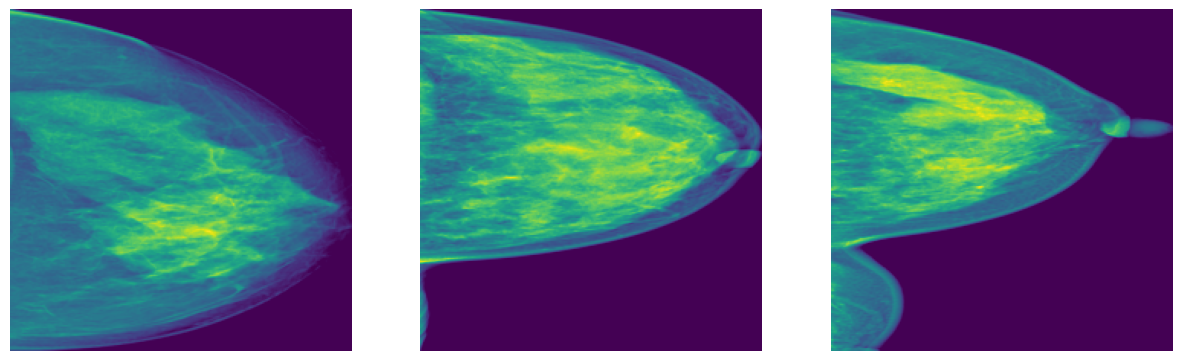

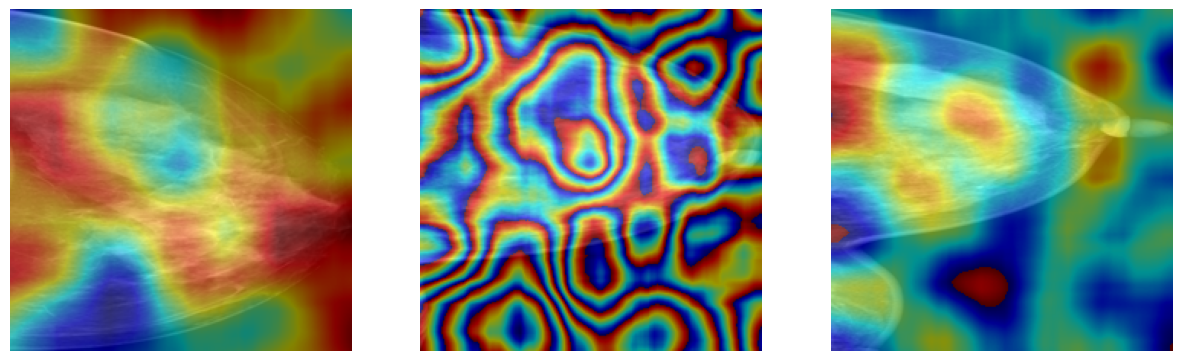

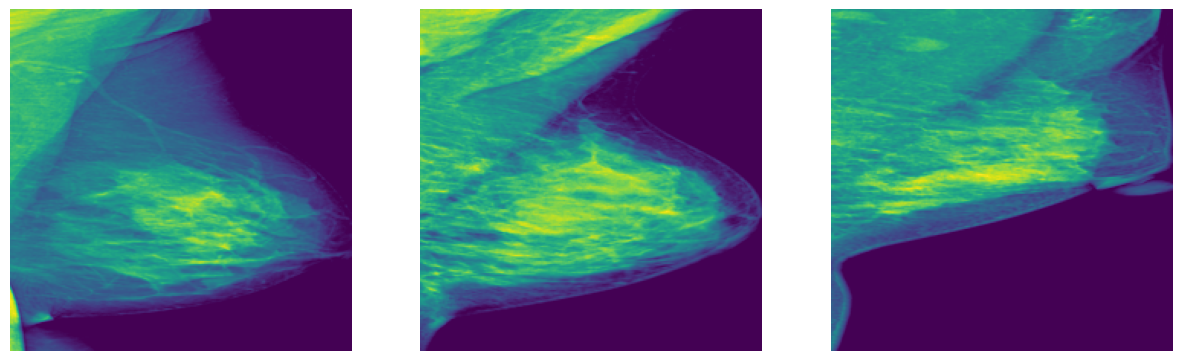

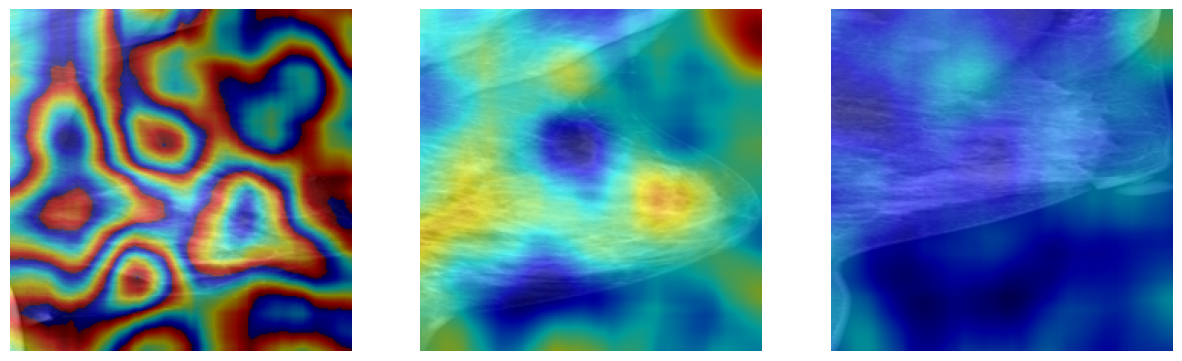

In [30]:
for i in range(0,2):
    
    importance_matrix1=output1[i]
    importance_matrix2=output2[i]
    importance_matrix1=importance_matrix1.numpy()
    importance_matrix2=importance_matrix2.numpy()
    importance_matrix3=importance_matrix1+importance_matrix2
    #importance_matrix3=max_matrix(importance_matrix1, importance_matrix2)

    
    i0_id=c1_df.iloc[i]
    i0_img=raw_input(i0_id[0],image_folder)
    
    i1_id=c2_df.iloc[i]
    i1_img=raw_input(i1_id[0],image_folder)
    
    i2_id=c3_df.iloc[i]
    i2_img=raw_input(i2_id[0],image_folder)
    
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    
    i0=overlay_heatmap(importance_matrix1,i0_img)
    i1=overlay_heatmap(importance_matrix3,i1_img)
    i2=overlay_heatmap(importance_matrix2,i2_img)
    
    
    
    axs[0].imshow(i0_img)
    axs[0].axis('off')

    axs[1].imshow(i1_img)
    axs[1].axis('off')
    
    axs[2].imshow(i2_img)
    axs[2].axis('off')
    
    ax[0].imshow(i0)
    ax[0].axis('off')
    
    ax[1].imshow(i1)
    ax[1].axis('off')
    
    ax[2].imshow(i2)
    ax[2].axis('off')
    
    plt.show()

    
    



    

    
    
    
    
    
    

tham chiếu ảnh rank 2 đến important_matrix1(1,2)=> áp dụng important_matrix1 cho ảnh 1,
tham chiếu ảnh rank 2 đến important_matrix2(2,3)=> áp dụng important_matrix1 cho ảnh 3,
áp dụng tổng 2 important_matrix trên cho ảnh 2

/tmp/ipykernel_34/1236448001.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i0_img=raw_input(i0_id[0],image_folder)
/tmp/ipykernel_34/1236448001.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i1_img=raw_input(i1_id[0],image_folder)
/tmp/ipykernel_34/1236448001.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i2_img=raw_input(i2_id[0],image_folder)


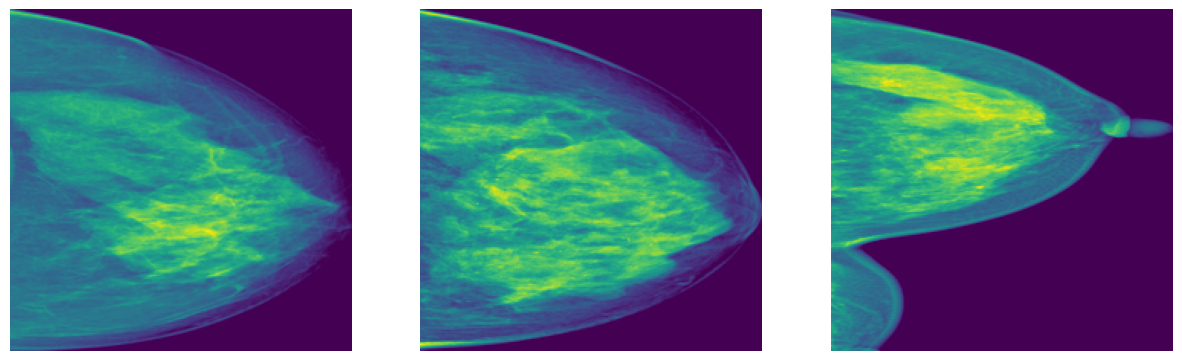

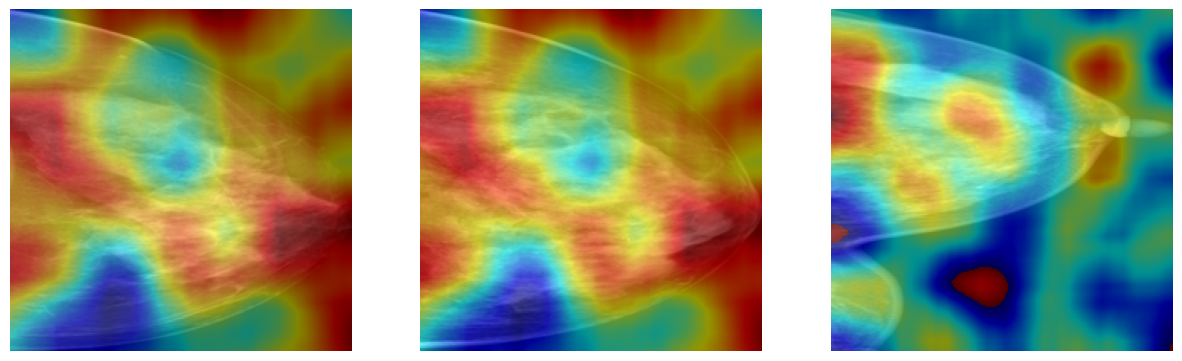

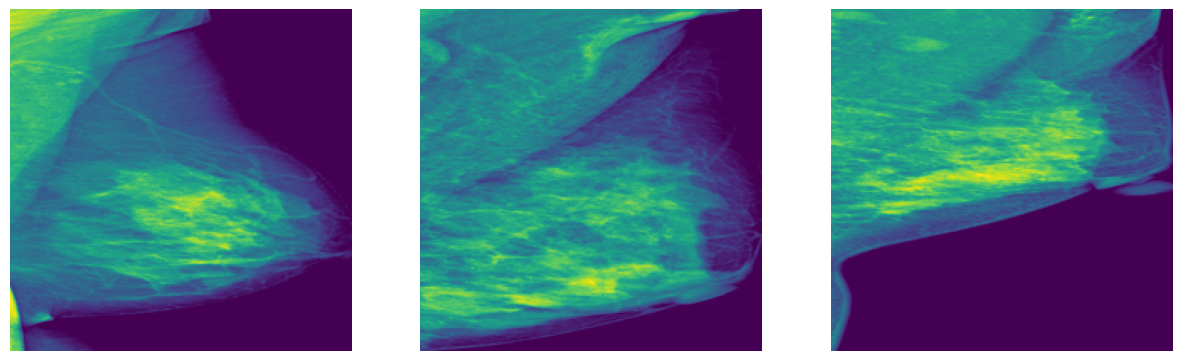

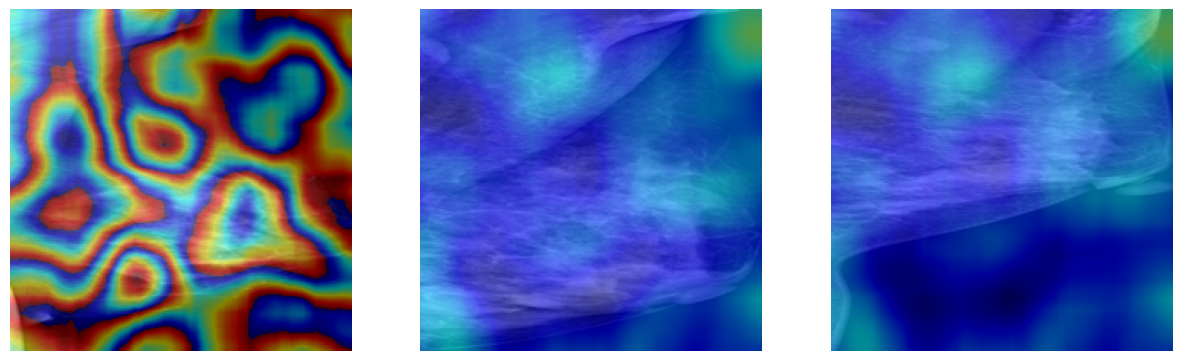

In [33]:
for i in range(0,2):
    
    importance_matrix1=output1[i]
    importance_matrix2=output2[i]


    importance_matrix1=importance_matrix1.numpy()
    importance_matrix2=importance_matrix2.numpy()
    importance_matrix3=max_matrix(importance_matrix1, importance_matrix2)

    
    i0_id=c1_df.iloc[i]
    i0_img=raw_input(i0_id[0],image_folder)
    
    i1_id=x2_df.iloc[i]
    i1_img=raw_input(i1_id[0],image_folder)
    
    i2_id=c3_df.iloc[i]
    i2_img=raw_input(i2_id[0],image_folder)
    
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    
    i0=overlay_heatmap(importance_matrix1,i0_img)
    i1=overlay_heatmap(importance_matrix3,i1_img)
    i2=overlay_heatmap(importance_matrix2,i2_img)
    
    
    
    axs[0].imshow(i0_img)
    axs[0].axis('off')

    axs[1].imshow(i1_img)
    axs[1].axis('off')
    
    axs[2].imshow(i2_img)
    axs[2].axis('off')
    
    ax[0].imshow(i0)
    ax[0].axis('off')
    
    ax[1].imshow(i1)
    ax[1].axis('off')
    
    ax[2].imshow(i2)
    ax[2].axis('off')
    
    plt.show()

    
    



    

    
    
    
    
    
    

tham chiếu ảnh rank 2 đến important_matrix1(1,2)=> áp dụng important_matrix1 cho ảnh 1,
tham chiếu ảnh rank 2 đến important_matrix2(2,3)=> áp dụng important_matrix1 cho ảnh 3,
áp dụng max của 2 important_matrix trên cho ảnh 2

In [54]:
from PIL import Image
# function return raw img 
def raw_input(img_id,folder):
    img_path = find_images(img_id, folder)
    i = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image to fit the model's input size
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        # Add more transformations if necessary
    ])
    image = preprocess(i)

    return image

    
